In [2]:
import numpy as np
import tensorflow as tf
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale
from skimage.transform import resize
import time
from scipy import optimize
from scipy.ndimage.interpolation import shift
from scipy.ndimage import gaussian_filter

In [3]:

data_temp = np.load('noah_wrist_manual.npy').astype(np.float32)
# data_temp = np.load('heart_rotation.npy').astype(np.float32)


print(data_temp.shape)

data_temp = data_temp/np.amax(data_temp)

im_0 = data_temp[0,:,:]
im_1 = data_temp[1,:,:]
im_2 = data_temp[2,:,:]
im_3 = data_temp[3,:,:]
im_4 = data_temp[4,:,:]
im_5 = data_temp[5,:,:]
im_6 = data_temp[6,:,:]
im_7 = data_temp[7,:,:]
im_8 = data_temp[8,:,:]


(25, 576, 577)


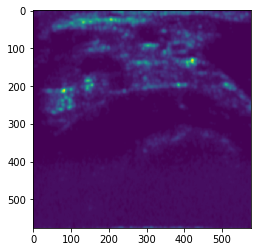

In [4]:
plt.imshow(gaussian_filter(im_0, 2))

In [6]:
def SNR(im):
    r = np.ravel(im)
    m = np.max(r)
    signal = r
    
    std = np.std(signal)
    return m/std

def find_rotation_and_translation(im_0, im_1, translation = (10,10), theta = (-5, 5), scale = 1.0):
    """Finds displacement and rotation of im_1 relative to im_0. 
    """
      
    sz = im_1.shape
    if sz[0]%2 == 1:
        im_0 = im_0[:-1]
        im_1 = im_1[:-1]
    if sz[1]%2 == 1:
        im_0 = im_0[:,:-1]
        im_1 = im_1[:,:-1]
    
    sz = im_1.shape
    
    max_vals = {
        'angle': 0,
        'translation': (0,0)
    }
    
    best_correlation = 0
    
    ##downsample ims?
    factor = 1.0 / scale
    
    im_0 = gaussian_filter(im_0, scale)
    im_1 = gaussian_filter(im_1, scale)

    im_0 = rescale(im_0, factor)
    im_1 = rescale(im_1, factor)
    
    for rotation_degree in np.arange(theta[0], theta[1]+1, step = 1):
        #search over rotation degrees  
        im_1_rotated = rotate(im_1, rotation_degree, reshape = False)
        im_1_rotated = np.clip(im_1_rotated,0, a_max= None)
        
        c = signal.fftconvolve(im_0, im_1_rotated[::-1,::-1], mode='same') 
        #if new max update max_vals
        midpoints = np.array(c.shape)/2
        peak_location = np.unravel_index(np.argmax(c), c.shape)

        SNR_ = SNR(c[(peak_location[0] - 50)*((peak_location[0] - 50)>0) : peak_location[0]+50, (peak_location[1] - 50)*((peak_location[1] - 50)>0): peak_location[1]+50])
        
#         print(SNR_)
        
        if  SNR_ > best_correlation:
            best_correlation = SNR_
            translation_a = (peak_location - midpoints) * scale
                        
            max_vals.update({
                'angle': rotation_degree,
                'translation': translation_a
            })
            
    return max_vals
    

/Users/noah/Documents/CHU/Ultrasound/Ultrasound/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


{'angle': 2, 'translation': array([  4., -24.])}
time 0.2587549686431885
translation [  4. -24.]
error_no_correction 132.85073852539062 with correction 69.72429656982422


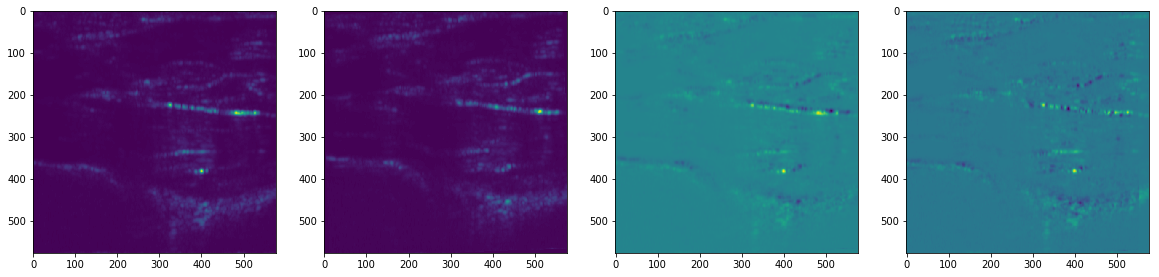

In [7]:
im_a = data_temp[16,:,:]
im_b = data_temp[17,:,:]

t_s = time.time()
out = find_rotation_and_translation(im_a, im_b,theta = (-10,10), scale = 4)
t_t = time.time()-t_s
print(out)
print("time {}".format(t_t))

im_b_ = rotate(im_b, out['angle'], reshape = False)
im_b_shift = shift(im_b_, out['translation'])
print("translation {}".format(out['translation']))

fig, ax = plt.subplots(1, 4, figsize = (20,30))
ax[0].imshow(im_a)
ax[1].imshow(im_b_)
ax[2].imshow(im_a-im_b_)
ax[3].imshow(im_a-im_b_shift)

print("error_no_correction {} with correction {}".format(np.sum(np.power(im_a-im_b_,2)), np.sum(np.power(im_a-im_b_shift,2))))



/Users/noah/Documents/CHU/Ultrasound/Ultrasound/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


total time 4.255764007568359


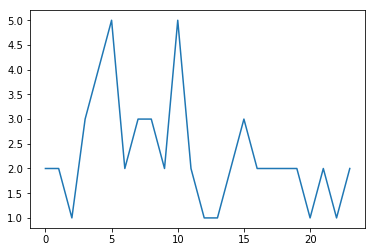

In [8]:
rotate_angs = []
displacements = []
time_s = time.time()
for image_num in np.arange(24):
    im_a = data_temp[image_num]
    im_b = data_temp[image_num+1]
    out = find_rotation_and_translation(im_a, im_b,theta = (-10,10), scale = 4)
    rotate_angs.append(out['angle'])
    displacements.append(out['translation'])

print("total time {}".format(time.time()- time_s))
plt.plot(rotate_angs)
    

In [9]:
rotate_angs_2 = [0]
displacements_2 = [(0,0)]
#calculate difference over 2 image steps
for image_num in np.arange(23):
    im_a = data_temp[image_num]
    im_b = data_temp[image_num+2]
    out = find_rotation_and_translation(im_a, im_b,theta = (-10,10), scale = 4)
    rotate_angs_2.append(out['angle'])
    displacements_2.append(out['translation'])


/Users/noah/Documents/CHU/Ultrasound/Ultrasound/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [10]:
len(rotate_angs)

24

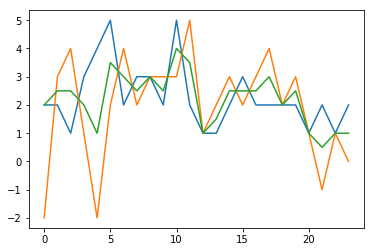

In [11]:
combine_2 = np.array(rotate_angs_2) - np.array(rotate_angs)
total = np.stack([np.array(rotate_angs), combine_2], axis = 0)
mean_angle = np.mean(total, axis = 0)
mean_angle[0] = rotate_angs[0] #sets first value to value calculated from single rotation

plt.plot(rotate_angs)
plt.plot(np.array(rotate_angs_2) - np.array(rotate_angs))
plt.plot(mean_angle)

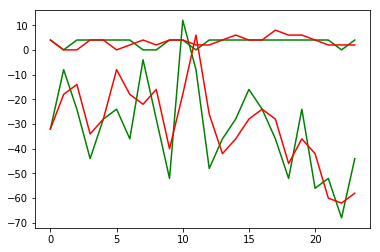

In [12]:
displacements_calc_2 = np.array(displacements_2) - np.array(displacements)
displacement_stack = np.stack([np.array(displacements), displacements_calc_2], axis = 0)
mean_displacement = np.mean(displacement_stack, axis = 0)
mean_displacement[0] = displacements[0] #sets first value to value calculated from single rotation

plt.plot(displacements, 'g')
# plt.plot(np.array(rotate_angs_2) - np.array(rotate_angs))
plt.plot(mean_displacement, 'r')

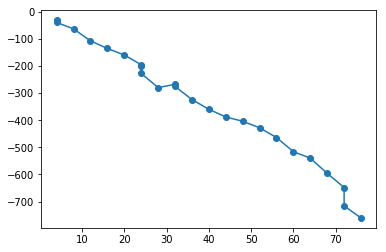

In [13]:
cum_sum_d = np.cumsum(np.array(displacements).T,axis=1)      # sum over rows for each of the 3 columns
plt.plot(cum_sum_d[0],cum_sum_d[1], '-o')

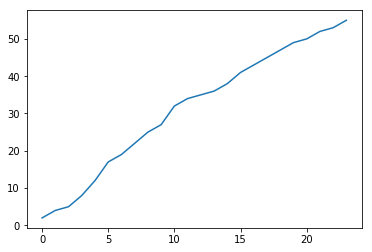

In [14]:
cum_sum_angle = np.cumsum(rotate_angs)
plt.plot(cum_sum_angle)

In [15]:
def rotate_and_place(im, total_plot_size, rotation_degrees, offset):
    '''places image in field with rotation and cartesian translation.
    
    First rotates, then offsets image in plane. 
    '''
    total_plot_size = np.array(total_plot_size, np.int)
    offset = np.array(offset, np.int)
    
    im_ = rotate(im, rotation_degrees, reshape = False)
    difference = total_plot_size - np.array(im_.shape)
    
    pad = [[offset[0], difference[0]-offset[0]],[offset[1], difference[1]-offset[1]]]
    prepared_ = np.pad(im_, pad, mode = 'constant')
    return prepared_
    

In [16]:
compare_image_0 = 0
compare_image_1 = 10

total_plot_size = [1000,1500]
initial_offset = [200, 600]

print("angle {}".format(cum_sum_angle[compare_image_1-1] - cum_sum_angle[compare_image_0-1]))
print("translation {}".format(cum_sum_d.T[compare_image_1-1] - cum_sum_d.T[compare_image_0-1] ))

im_0_prepared = rotate_and_place(data_temp[compare_image_0], total_plot_size, cum_sum_angle[compare_image_0-1], cum_sum_d.T[compare_image_0-1] + initial_offset)
im_1_prepared = rotate_and_place(data_temp[compare_image_1], total_plot_size, cum_sum_angle[compare_image_1-1], cum_sum_d.T[compare_image_1-1] + initial_offset)

print(im_0_prepared.shape)

fig,ax = plt.subplots(1,3, figsize = (25,25))
ax[0].imshow(im_0_prepared)
ax[1].imshow(im_1_prepared)
ax[2].imshow(im_0_prepared+im_1_prepared)


angle -28
translation [-48. 480.]


ValueError: [[276, 148], [-160, 1083]] cannot contain negative values.

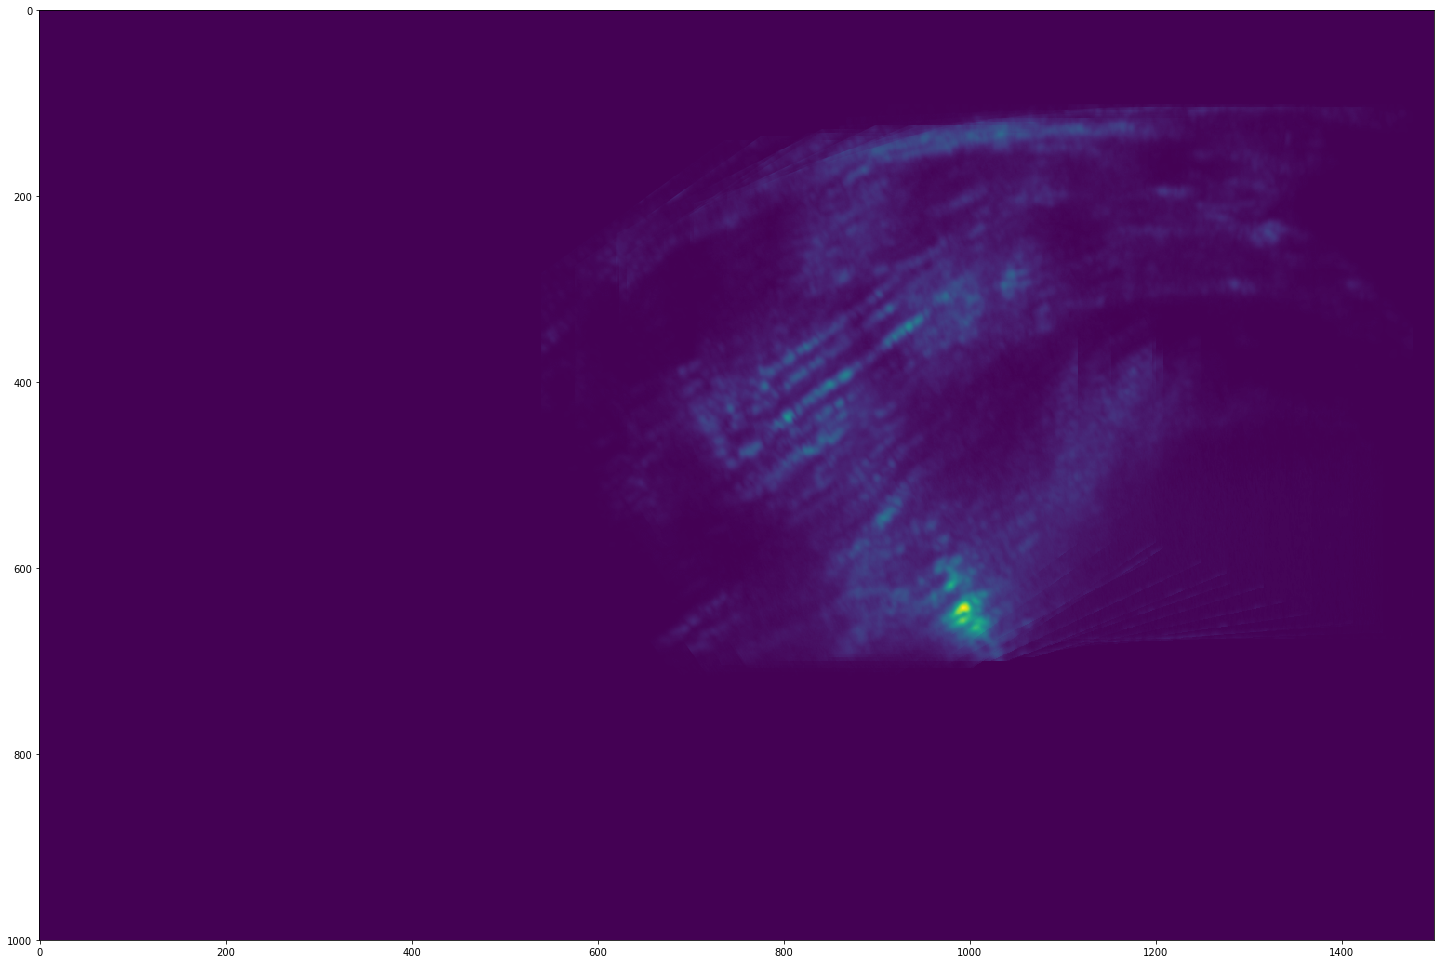

In [18]:
total_plot_size = [1000,1500]
initial_offset = [100, 900]

total_plot = rotate_and_place(data_temp[0], total_plot_size, 0, initial_offset)

for image_iter in np.arange(1,15,1):
    total_plot  = total_plot + rotate_and_place(data_temp[image_iter], total_plot_size, cum_sum_angle[image_iter-1], cum_sum_d.T[image_iter-1] + initial_offset)
    
plt.figure(figsize = (25,25))
plt.imshow(total_plot)

